In [229]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

In [230]:
#Parameters
env_r = 5
num_cells = 2
Tsim = 120 #number of minutes to run simulation
dt = 10 # minutes between each simulation step 
N = int(Tsim/dt) # Number of iterations to run 

# labeling for cells 
num_cells_sp1 = 1 #number of cells in species 1
num_cells_sp2 = 1 # number of cells in species 2
cell_ids_1 = ["o_" + str(cell_id) for cell_id in range(num_cells_sp1)] # unique ids for each cell in species 1 with species identifier
cell_ids_2 = ["t_" + str(cell_id) for cell_id in range(num_cells_sp2)] # unique ids for each cell in species 2 with species identifier
cell_ids = cell_ids_1 + cell_ids_2
species = ["one", "two"]

#initialize angle 
cell_theta_init = [random.uniform(0, 360) for _ in range(len(cell_ids))]
#initialize distance from origin
cell_dist_init = [random.uniform(0, env_r) for _ in range(len(cell_ids))]

coordinates = [calculate_cartesian_coords(theta, dist) for theta, dist in zip(cell_theta_init, cell_dist_init)]
xs_init, ys_init = zip(*coordinates)

df = pd.DataFrame({
    'species': species,
    'cell_ids': cell_ids,
    't': [0] * len(cell_ids),
    'x': xs_init,
    'y': ys_init
})

In [231]:
def is_in_boundary(cell_position: list[int], r_env = 5):
  '''
  Parameters: 
  r: radius of defined region for cells
  cell_position: list for a single cell with x and y position
  Return: 
  true: within region
  false: exited region
  '''
  x = cell_position[0]
  y = cell_position[1]

  if np.sqrt(x**2 + y**2) < r_env:
    return True
  else: 
    return False

def calculate_cartesian_coords(theta, r):
  cos = np.cos(theta)
  sin = np.sin(theta)
  x = cos*r
  y = sin*r
  return [x, y]

def calculate_polar_coords(x, y):
  r = np.sqrt(x**2 + y**2)
  theta = np.arctan2(y, x)
  return [theta, r]

[]

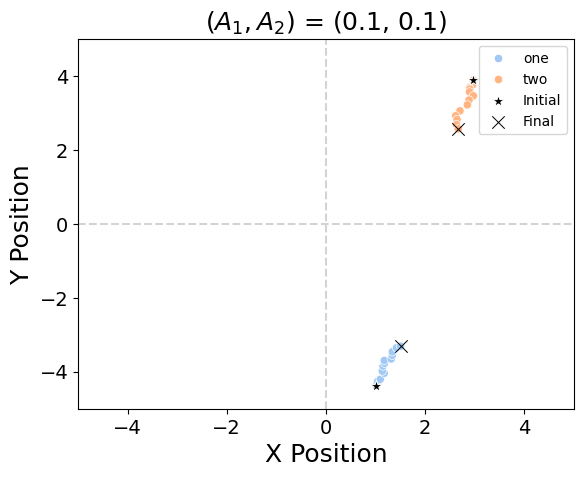

In [232]:
def sp_attracting(t, cell_ids: list[str], attraction_coefs: list[float]):
  '''behavior of different species attracting/repelling'''

  # cell ids and attraction to eachother
  cell_sp1, cell_sp2 = cell_ids
  coef_sp1, coef_sp2 = attraction_coefs  # Coefficients for sp1 -> sp2 and sp2 -> sp1
  # angle of each from original, and distance from origin
  x_sp1 = df.loc[(df['cell_ids'] == cell_sp1) & (df['t'] == t), 'x'].values[0]
  y_sp1 = df.loc[(df['cell_ids'] == cell_sp1) & (df['t'] == t), 'y'].values[0]
  x_sp2 = df.loc[(df['cell_ids'] == cell_sp2) & (df['t'] == t), 'x'].values[0]
  y_sp2 = df.loc[(df['cell_ids'] == cell_sp2) & (df['t'] == t), 'y'].values[0]

  #distance used for normalization
  distance = np.sqrt((x_sp2 - x_sp1)**2 + (y_sp2 - y_sp1)**2)
  # normalized direction vector from sp1 to sp2

  x_direction_sp1 = (x_sp2 - x_sp1) / distance
  y_direction_sp1 = (y_sp2 - y_sp1) / distance

  x_direction_sp2 = (x_sp1 - x_sp2) / distance
  y_direction_sp2 = (y_sp1 - y_sp2) / distance

  #new coordinates 
  noise_std = 0.05
  x_sp1_next = x_sp1 + coef_sp1 * x_direction_sp1 + np.random.normal(0, noise_std)
  y_sp1_next = y_sp1 + coef_sp1 * y_direction_sp1 + np.random.normal(0, noise_std)
  
  if is_in_boundary([x_sp1_next, y_sp1_next]) == False: 
    x_sp1_next, y_sp1_next = x_sp1, y_sp1

  x_sp2_next = x_sp2 + coef_sp2 * x_direction_sp2 + np.random.normal(0, noise_std)
  y_sp2_next = y_sp2 + coef_sp2 * y_direction_sp2 + np.random.normal(0, noise_std)

  if is_in_boundary([x_sp2_next, y_sp2_next]) == False: 
    x_sp2_next, y_sp2_next = x_sp2, y_sp2

  return [x_sp1_next, y_sp1_next], [x_sp2_next, y_sp2_next]

A1, A2 = [.1, .1]

for i in range(0, N):
  for cell_sp1 in cell_ids_1:
    for cell_sp2 in cell_ids_2:
      if i == 0:
        x_sp1 = df.loc[(df['cell_ids'] == cell_sp1) & (df['t'] == i), 'x'].values[0]
        y_sp1 = df.loc[(df['cell_ids'] == cell_sp1) & (df['t'] == i), 'y'].values[0]
        x_sp2 = df.loc[(df['cell_ids'] == cell_sp2) & (df['t'] == i), 'x'].values[0]
        y_sp2 = df.loc[(df['cell_ids'] == cell_sp2) & (df['t'] == i), 'y'].values[0]

      [x_sp1_next, y_sp1_next], [x_sp2_next, y_sp2_next] = sp_attracting(i, [cell_sp1, cell_sp2], [A1, A2])  # cell from sp2 attracted to cell from sp1
      df.loc[len(df)] = ({'cell_ids': cell_sp1, 't': i+1, 'x': x_sp1_next, 'y': y_sp1_next, "species": "one"})
      df.loc[len(df)] = ({'cell_ids': cell_sp2, 't': i+1, 'x': x_sp2_next, 'y': y_sp2_next, "species": "two"})


plt.axvline(0, linestyle = "--", color = "lightgrey")
plt.axhline(0, linestyle = "--", color = "lightgrey")
plt.xlim(-env_r, env_r)
plt.ylim(-env_r, env_r)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.xlabel("X Position", fontsize = 18)
plt.ylabel("Y Position", fontsize = 18)

sns.scatterplot(x = "x", y = "y", data = df, hue = "species", palette = "pastel")
sns.scatterplot(data=df[df['t'] == 0], x='x', y='y',  marker= "*", color = "black", label='Initial', s = 80)
sns.scatterplot(data=df[df['t'] == N], x='x', y='y', marker='x', color='black', label='Final', s = 80)

plt.title(rf"$(A_1, A_2)$ = ({A1}, {A2})", fontsize = 18)

plt.plot()
#print(df.sort_values(by = ["cell_ids", "t"]))